<a href="https://colab.research.google.com/github/voquyen0502/Protein-Ligand-Binding-Affinity/blob/main/KISS_GP_Protein_Ligand_Affinity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Library

In [ ]:
%%html
<audio src="https://oobabooga.github.io/silence.m4a" controls>
warnings.filterwarnings(action='once')

In [ ]:
# !pip install -U sentence-transformers
!pip install gpytorch

#Import Library

In [ ]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from scipy.stats import spearmanr
import os
import re
import glob
import gc
import time

import math
import tqdm
from tqdm.notebook import tqdm as tqdm1
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

#Support Functions

In [ ]:
def format_time(time):
  if len(time) < 2:
    return "0"+time
  return time
def to_time(t):
  s = format_time(str(t%60))
  m = format_time(str(t//60%60))
  h = format_time(str(t//3600))
  return h+":"+m+":"+s
def progress_bar(desc, t, i, n):
  eta = int(t*(n-i)/i) if i else 0
  pg = round(i*40/n)
  print('\r'+desc, '[ elapsed:', to_time(t),']', "|"+"="*pg+" "*(40-pg)+"|", str(round(i*100/n))+"%", '( ETA:', to_time(eta), ')', end="", flush=True)

In [ ]:
def evaluate(X, y):
    yhat = GPs(X).mean
    mse = mean_squared_error(y, yhat)
    rmse = mean_squared_error(y, yhat, squared = False)
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    spearman = spearmanr(y, yhat).correlation
    r2 = r2_score(y, yhat)
    return [mse, rmse, mae, mape, spearman, r2]

In [ ]:
def plt_train_test(x_values, err_train, err_test, x_label, title):
    fig, ax = plt.subplots(3, 2, figsize=(8, 12))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    errors = ['MSE', 'RMSE', 'MAE', 'MAPE', 'Spearman', 'R-squared']
    for i in range(6):
        w = i%2
        h = i//2
        ax[h][w].set_title(errors[i],fontsize = 12)
        ax[h][w].plot(x_values, [err_train[j][i] for j in range(len(x_values))], marker='o',label="train error", lw=2,  color = "blue")
        ax[h][w].plot(x_values, [err_test[j][i] for j in range(len(x_values))],    marker='o',label="test error",  lw=2, color = "green")
        ax[h][w].set_ylim(*ax[h][w].get_ylim())
        ax[h][w].set_xlabel(x_label)
        ax[h][w].set_ylabel("Error")
        ax[h][w].legend()
    fig.suptitle(title,fontsize = 12)
    plt.tight_layout()
    plt.show()

In [ ]:
def plt_train_test_eval(x_values, err_train, err_test, x_label, title):
    fig, ax = plt.subplots(3, 2, figsize=(8, 12))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    errors = ['MSE', 'RMSE', 'MAE', 'MAPE', 'Spearman', 'R-squared']
    for i in range(6):
        w = i%2
        h = i//2
        ax[h][w].set_title(errors[i],fontsize = 12)
        ax[h][w].plot(x_values, [err_train[j][i] for j in range(len(x_values))], label="train error", lw=1,  color = "blue")
        ax[h][w].plot(x_values, [err_test[j][i] for j in range(len(x_values))], label="valid error",  lw=1, color = "green")
        ax[h][w].set_ylim(*ax[h][w].get_ylim())
        ax[h][w].set_xlabel(x_label)
        ax[h][w].set_ylabel("Error")
        ax[h][w].legend()
    fig.suptitle(title,fontsize = 12)
    plt.tight_layout()
    plt.show()

#Download Dataset

In [ ]:
!gdown 18S8MYwxljaYPYYn5QqlvFDN1myBwQunA
df = pd.read_csv('feature.csv', index_col=0)

Downloading...
From: https://drive.google.com/uc?id=18S8MYwxljaYPYYn5QqlvFDN1myBwQunA
To: /content/feature.csv
100% 191M/191M [00:03<00:00, 54.9MB/s]


#Preprocessing

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1783,1784,1785,1786,1787,1788,1789,1790,1791,label
0,-0.211700,-0.205539,0.337126,-0.056080,0.119349,0.243540,-0.126496,0.264932,0.315239,-0.118922,...,-0.315158,-0.742068,0.517479,0.007870,-0.881757,0.433979,0.381069,-0.682113,0.717024,5.486783
1,-0.189175,-0.087662,0.233187,0.127165,0.137902,0.147014,-0.202607,0.169478,0.213779,-0.248068,...,-0.063049,-0.192722,-0.550342,0.057612,0.100607,0.089984,0.683167,0.459728,-0.452435,3.602060
2,0.082610,-0.320745,-0.124809,0.018967,0.165369,-0.143138,-0.391910,-0.077087,-0.069667,-0.388979,...,-0.404161,-0.843317,0.149106,0.767675,-0.909352,0.172291,0.703071,0.504158,-0.543714,7.920819
3,-0.084273,-0.101664,0.112304,0.102400,0.110600,0.081240,-0.236201,0.104819,0.113949,-0.268406,...,-0.475812,-0.822818,-0.425321,0.856794,-0.981262,0.020445,0.348573,-0.298878,-0.356281,9.096910
4,-0.238835,0.028666,0.330590,0.121576,0.108433,0.286374,-0.096377,0.277651,0.297153,-0.141224,...,-0.173999,-0.601604,0.617227,-0.180792,-0.954172,0.354371,0.056249,-0.505679,0.303446,3.332547


In [ ]:
X = df.drop('label', axis = 1).values.astype(np.float32)
y = df.label.values.astype(np.float32)
X = torch.tensor(X)
y = torch.tensor(y)

In [ ]:
X_, X_test, y_, y_test = train_test_split(X, y, train_size = 0.8, random_state=42, shuffle = True)

In [ ]:
data_dim = X_.size(-1)
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(1000, 1000))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(1000, 1000))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(1000, 2))

feature_extractor = LargeFeatureExtractor()

In [ ]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, X_train, y_train, likelihood):
            super(GPRegressionModel, self).__init__(X_train, y_train, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
                num_dims=2, grid_size=100
            )
            self.feature_extractor = feature_extractor

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.feature_extractor(x)
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
def train(X, y, epoch, patience = 0):
    iterator = tqdm1(range(epoch))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = GPs(X)
        # Calc loss and backprop derivatives
        loss = -mll(output, y)
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()

In [ ]:
epoch = 500
ratio = [0.5, 0.75, X_.shape[0]-1]
ratio_str = ['50%', '75%', '100%']
train_err_ratio = []
test_err_ratio = []
for rt in ratio:
    X_train, _, y_train, _ = train_test_split(X_, y_, train_size = rt)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    GPs = GPRegressionModel(X_train, y_train, likelihood)

    if torch.cuda.is_available():
        GPs = GPs.cuda()
        likelihood = likelihood.cuda()

    # Find optimal model hyperparameters
    GPs.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': GPs.feature_extractor.parameters()},
        {'params': GPs.covar_module.parameters()},
        {'params': GPs.mean_module.parameters()},
        {'params': GPs.likelihood.parameters()},
    ], lr=0.01)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, GPs)
    %time train(X_train, y_train, epoch)
    GPs.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        train_err_ratio += [evaluate(X_, y_)]
        test_err_ratio += [evaluate(X_test, y_test)]

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():


CPU times: user 13min 13s, sys: 1min 29s, total: 14min 43s
Wall time: 7min 21s


  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 18min 13s, sys: 2min 48s, total: 21min 2s
Wall time: 10min 31s


  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 23min 2s, sys: 3min 45s, total: 26min 48s
Wall time: 13min 25s


#Evaluating

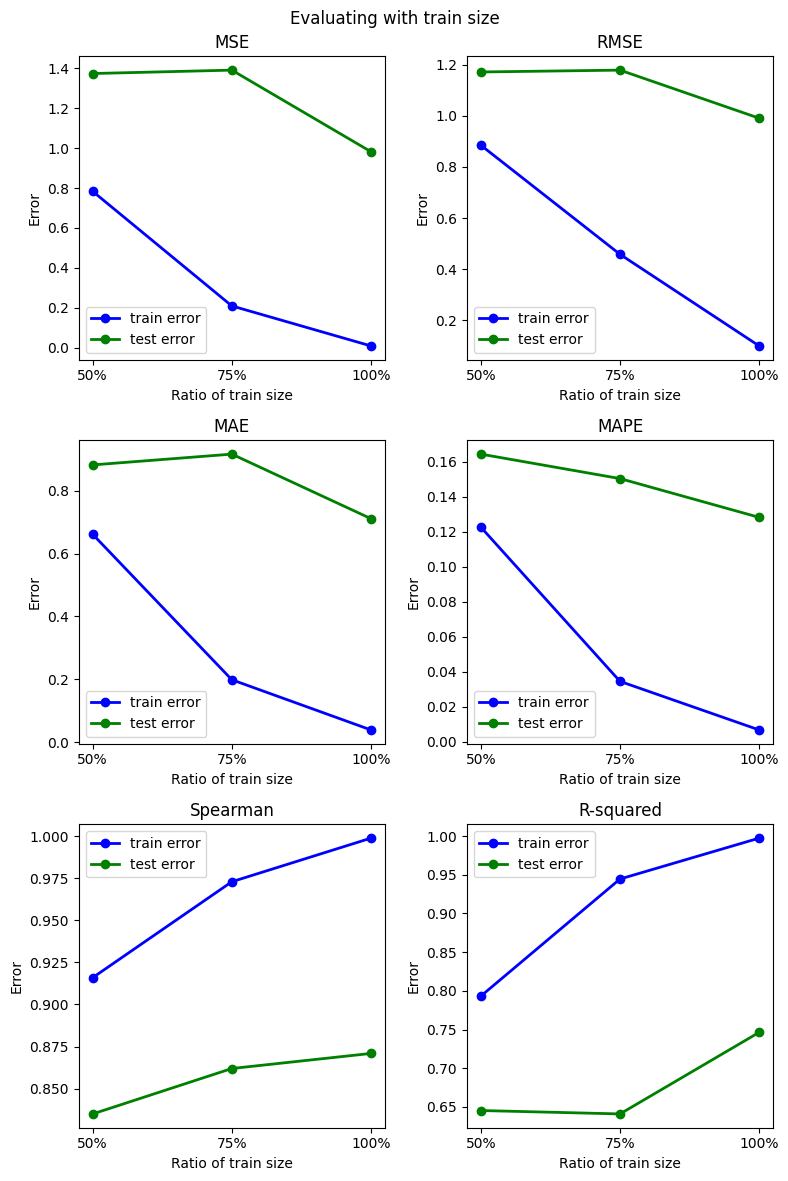

In [ ]:
plt_train_test(ratio_str, train_err_ratio, test_err_ratio, 'Ratio of train size', 'Evaluating with train size')

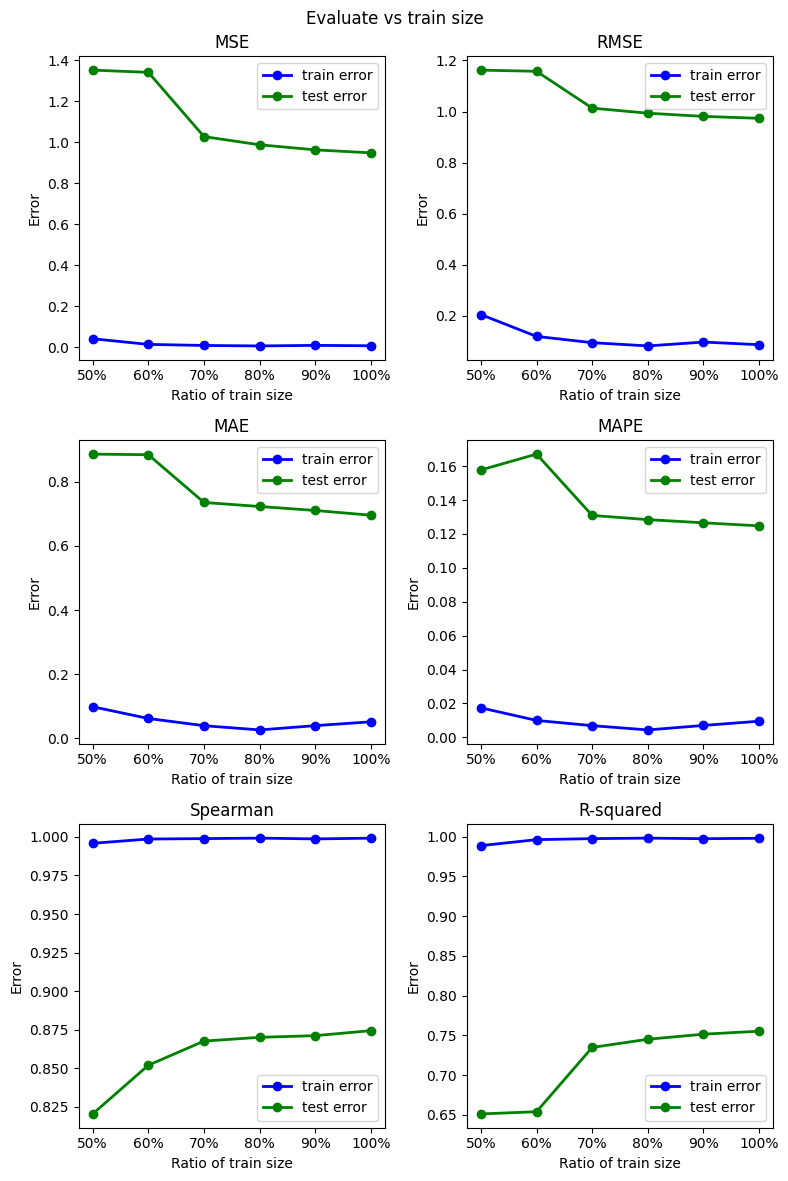

In [ ]:
GPs.eval()
likelihood.eval()
eval = pd.DataFrame()
eval['Error'] = ['MSE', 'RMSE', 'MAE', 'MAPE', 'Spearman', 'R-Squared']
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
  eval['Train set'] = evaluate(X_train, y_train)
  eval['Test set'] = evaluate(X_test, y_test)
eval


/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


,Error,Train set,Test set
0,MSE,0.010028,0.981689
1,RMSE,0.100140,0.990802
2,MAE,0.039532,0.710734
3,MAPE,0.006729,0.128114
4,Spearman,0.998850,0.870904
5,R-Squared,0.997351,0.746389


#Epoch

In [ ]:
def train_with_eval(X_train, y_train, X_val, y_val, epoch, train_err, valid_err):
    iterator = tqdm1(range(epoch))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = GPs(X_train)
        # Calc loss and backprop derivatives
        loss = -mll(output, y_train)
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()
        likelihood.eval()
        GPs.eval()
        with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
            train_err+=[evaluate(X_train, y_train)]
            valid_err+=[evaluate(X_val, y_val)]
        likelihood.train()
        GPs.train()

In [ ]:
train_err_epoch_2 = []
valid_err_epoch_2 = []
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.25)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
GPs = GPRegressionModel(X_train, y_train, likelihood)
if torch.cuda.is_available():
    GPs = GPs.cuda()
    likelihood = likelihood.cuda()

# Find optimal model hyperparameters
GPs.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': GPs.feature_extractor.parameters()},
    {'params': GPs.covar_module.parameters()},
    {'params': GPs.mean_module.parameters()},
    {'params': GPs.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, GPs)

%time train_with_eval(X_train, y_train, X_val, y_val, epoch, train_err_epoch_2, valid_err_epoch_2)

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpytorch/models/exac

CPU times: user 35min 27s, sys: 2min 52s, total: 38min 19s
Wall time: 19min 10s


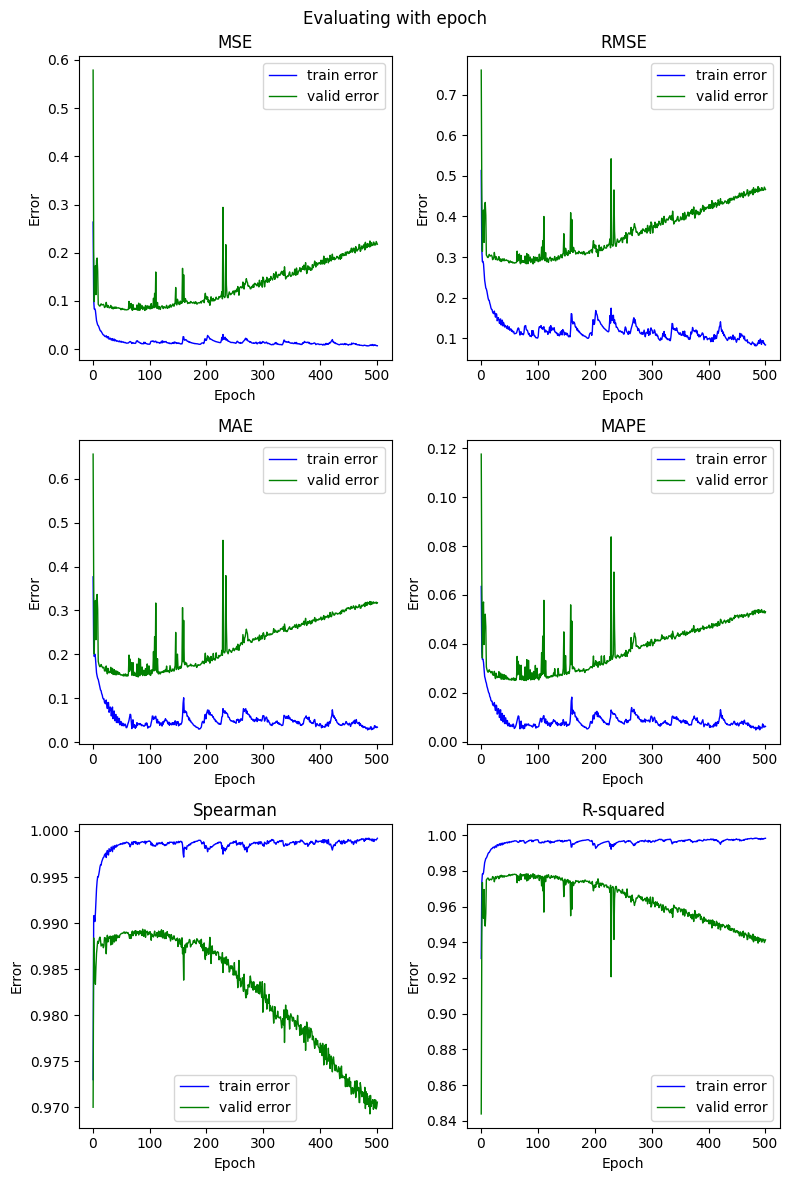

In [ ]:
plt_train_test_eval(list(range(1, 501)), train_err_epoch_2, valid_err_epoch_2, 'Epoch', 'Evaluating with epoch')

In [ ]:
GPs.eval()
likelihood.eval()
eval = pd.DataFrame()
eval['Error'] = ['MSE', 'RMSE', 'MAE', 'MAPE', 'Spearman', 'R-Squared']
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
  eval['Train set'] = evaluate(X_train, y_train)
  eval['Valid set'] = evaluate(X_val, y_val)
  eval['Test set'] = evaluate(X_test, y_test)
eval

/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


,Error,Train set,Valid set,Test set
0,MSE,0.006918,0.217597,0.982857
1,RMSE,0.083177,0.466473,0.991392
2,MAE,0.034426,0.317499,0.701076
3,MAPE,0.006220,0.053044,0.125534
4,Spearman,0.999210,0.970550,0.868986
5,R-Squared,0.998187,0.941317,0.746087


In [ ]:
def train_with_early_stopping(X_train, y_train, X_val, y_val, epoch, patience, train_err, valid_err):
    last_loss = np.inf
    trigger_times = 0
    iterator = tqdm1(range(epoch))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = GPs(X_train)
        # Calc loss and backprop derivatives
        loss = -mll(output, y_train)
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()
        likelihood.eval()
        GPs.eval()
        with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
            loss_train = evaluate(X_train, y_train)
            loss_val = evaluate(X_val, y_val)
            train_err+=[loss_train]
            valid_err+=[loss_val]
        if loss_val[0] > last_loss:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                return
        else:
            trigger_times = 0
        last_loss = loss_val[0]
        likelihood.train()
        GPs.train()

In [ ]:
train_err_early = []
valid_err_early = []
likelihood = gpytorch.likelihoods.GaussianLikelihood()
GPs = GPRegressionModel(X_train, y_train, likelihood)
if torch.cuda.is_available():
    GPs = GPs.cuda()
    likelihood = likelihood.cuda()

# Find optimal model hyperparameters
GPs.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': GPs.feature_extractor.parameters()},
    {'params': GPs.covar_module.parameters()},
    {'params': GPs.mean_module.parameters()},
    {'params': GPs.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, GPs)
patience = 5
%time train_with_early_stopping(X_train, y_train, X_val, y_val, epoch, patience, train_err_early, valid_err_early)

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpytorch/models/exac

Early stopping!
CPU times: user 1min 4s, sys: 5.51 s, total: 1min 10s
Wall time: 35.3 s


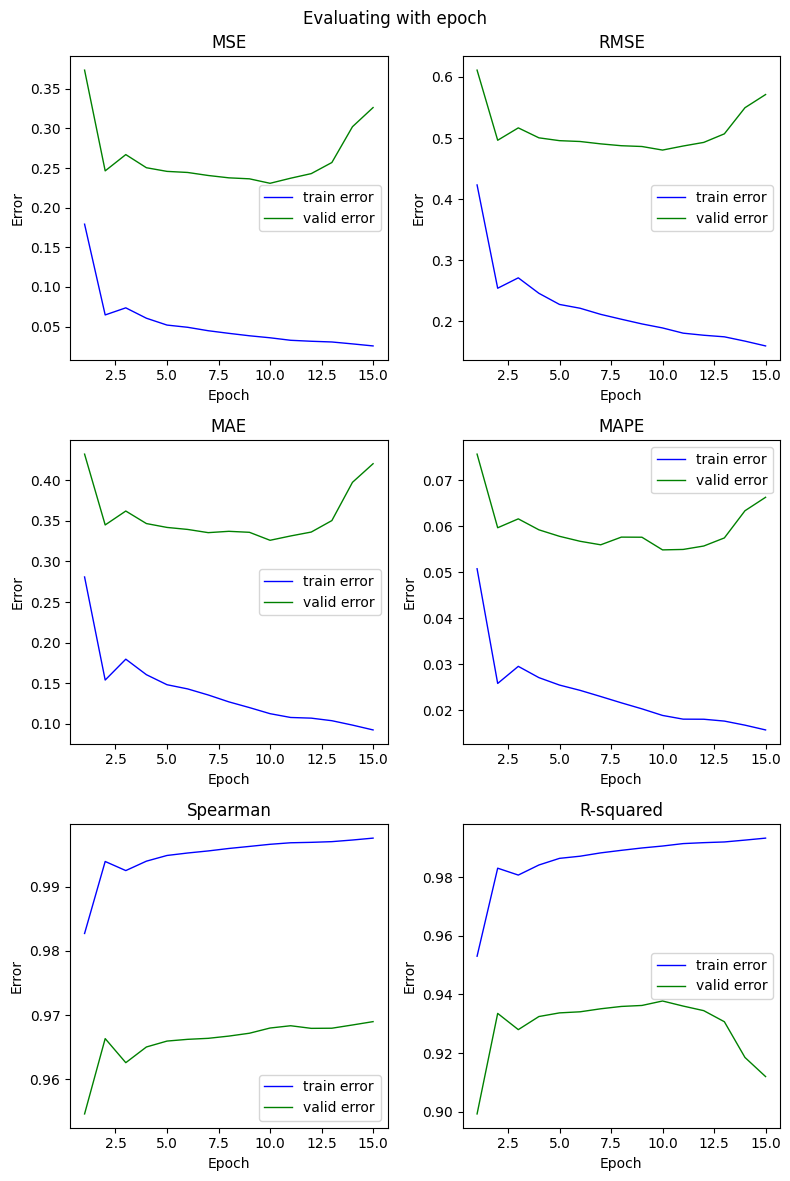

In [ ]:
plt_train_test_eval(list(range(1, len(valid_err_early)+1)), train_err_early, valid_err_early, 'Epoch', 'Evaluating with epoch')

In [ ]:
GPs.eval()
likelihood.eval()
eval = pd.DataFrame()
eval['Error'] = ['MSE', 'RMSE', 'MAE', 'MAPE', 'Spearman', 'R-Squared']
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
  eval['Train set'] = evaluate(X_train, y_train)
  eval['Valid set'] = evaluate(X_val, y_val)
  eval['Test set'] = evaluate(X_test, y_test)
eval

/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


,Error,Train set,Valid set,Test set
0,MSE,0.025579,0.326382,1.128176
1,RMSE,0.159935,0.571298,1.062156
2,MAE,0.092440,0.420387,0.807187
3,MAPE,0.015673,0.066311,0.133993
4,Spearman,0.997551,0.968975,0.872548
5,R-Squared,0.993296,0.911978,0.708545


In [ ]:
lamdas = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]
lamdas_str = ["0.001", "0.002", "0.005", "0.01", "0.02", "0.05", "0.1"]
train_err_lamda = []
test_err_lamda = []
for ld in lamdas:
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    GPs = GPRegressionModel(X_, y_, likelihood)

    if torch.cuda.is_available():
        GPs = GPs.cuda()
        likelihood = likelihood.cuda()

    # Find optimal model hyperparameters
    GPs.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': GPs.feature_extractor.parameters()},
        {'params': GPs.covar_module.parameters()},
        {'params': GPs.mean_module.parameters()},
        {'params': GPs.likelihood.parameters()},
    ], lr=0.01, weight_decay = ld)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, GPs)
    train_err = []
    valid_err = []
    %time train(X_, y_, epoch)
    GPs.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        train_err_lamda += [evaluate(X_, y_)]
        test_err_lamda += [evaluate(X_test, y_test)]

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 23min 38s, sys: 3min 51s, total: 27min 30s
Wall time: 13min 47s


/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 23min 9s, sys: 3min 53s, total: 27min 3s
Wall time: 13min 33s


/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 22min 55s, sys: 3min 49s, total: 26min 44s
Wall time: 13min 24s


/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 22min 44s, sys: 3min 48s, total: 26min 32s
Wall time: 13min 18s


/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 22min 40s, sys: 3min 49s, total: 26min 29s
Wall time: 13min 16s


/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 22min 41s, sys: 3min 48s, total: 26min 30s
Wall time: 13min 17s


/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 22min 37s, sys: 3min 48s, total: 26min 26s
Wall time: 13min 14s


/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


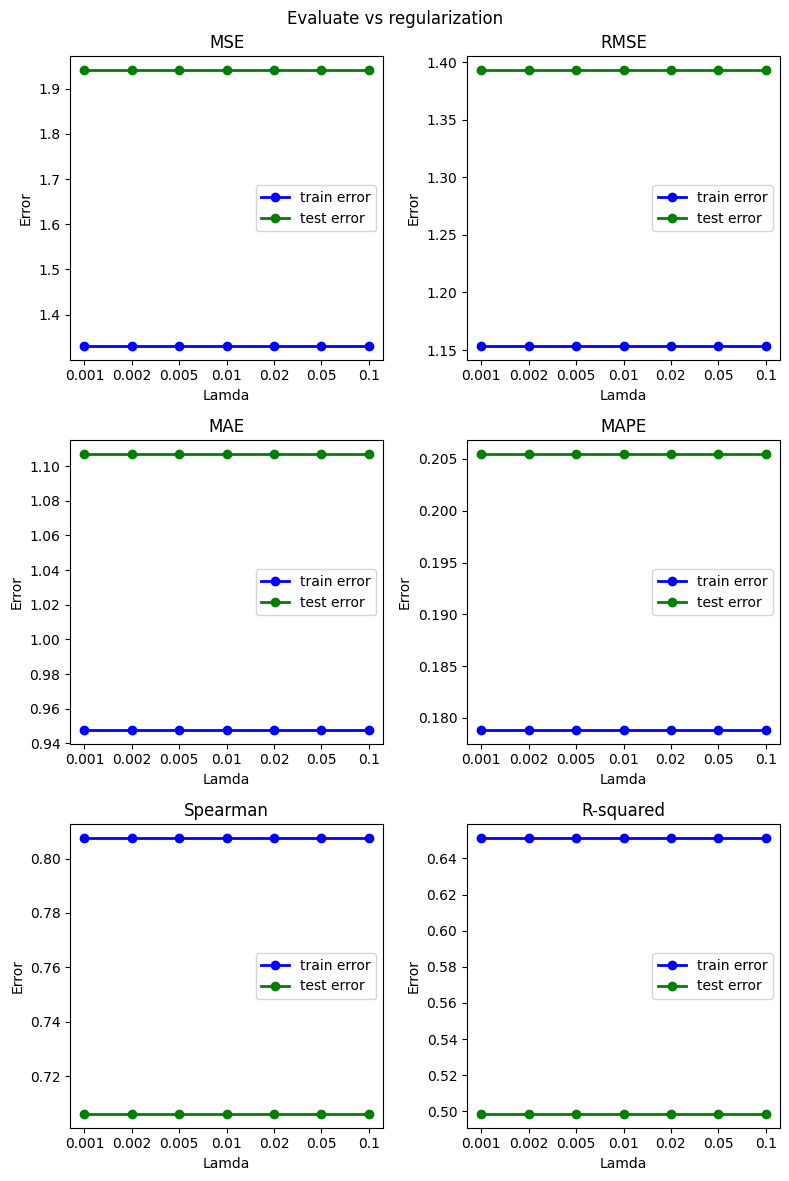

In [ ]:
plt_train_test(lamdas_str, train_err_lamda, test_err_lamda, 'Lamda', 'Evaluate vs regularization')

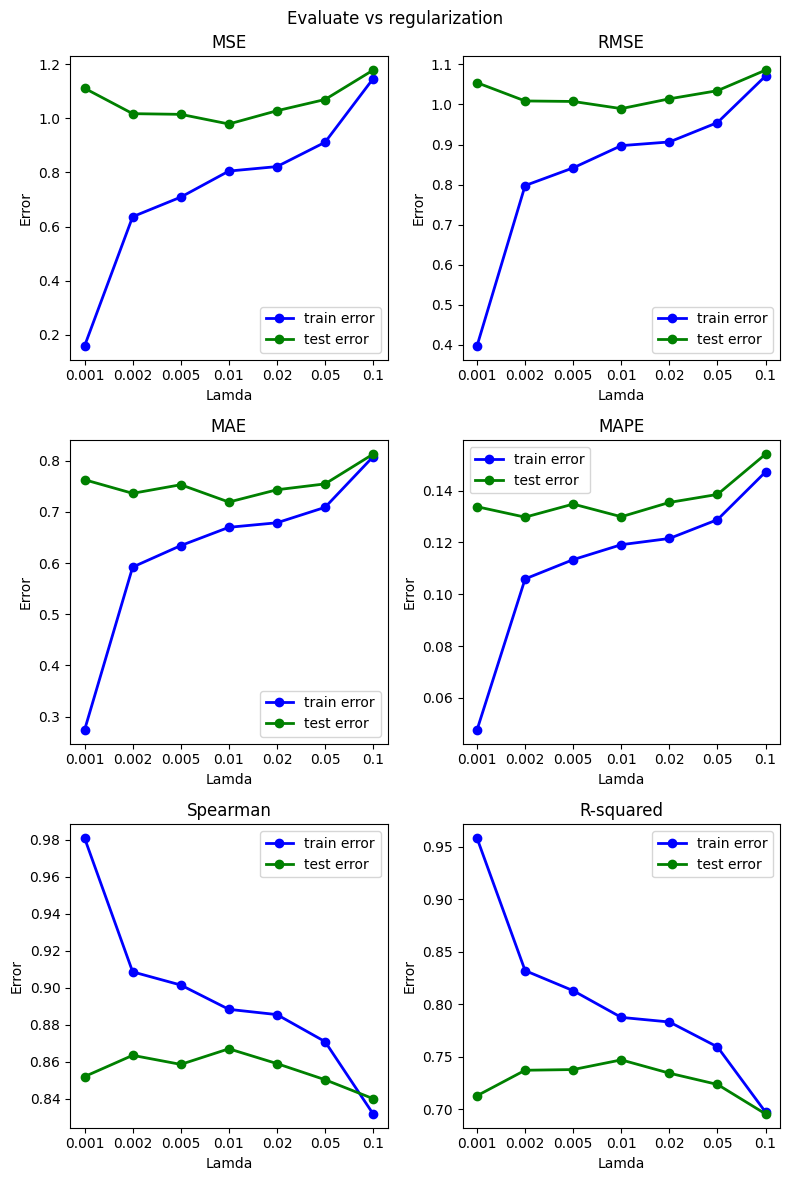